In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## running the model

In [3]:
from gaze import init
args = init(verbose=1)
print('Parameters=', args)


Parameters= {'dataset_folder': 'dataset_faces', 'batch_size': 8, 'test_batch_size': 1, 'valid_size': 0.2, 'epochs': 20, 'do_adam': False, 'lr': 0.05, 'momentum': 0.18, 'no_cuda': False, 'num_processes': 1, 'seed': 42, 'log_interval': 0, 'fullsize': 64, 'crop': 64, 'size': 64, 'mean': 0.36, 'std': 0.3, 'conv1_dim': 7, 'conv1_kernel_size': 7, 'conv2_dim': 13, 'conv2_kernel_size': 7, 'stride1': 2, 'stride2': 4, 'N_cv': 20, 'dimension': 30, 'verbose': 1}


In [4]:
from gaze import ML
ml = ML(args)

import os
import torch

path = '_Regard.pt'
ml.model.load_state_dict(torch.load(path))
print('Loading file', path)


from torchvision import transforms
t = transforms.Compose([
    transforms.Resize(args.fullsize),    
    transforms.CenterCrop(args.crop),
    transforms.Resize(args.size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[args.mean]*3, std=[args.std]*3),
    ])


cuda? False
no cuda? True
Found 640 sample images;  512  to train 128 to test
Loading file _Regard.pt


In [5]:
ml.dataset.dataset.classes

['blink', 'center', 'left', 'right']

In [6]:
targets = {}
s_target = 'üî¥'
s_fixat = 'üîµ'
s_distra = 'üå´'
s_blink = '‚ò†Ô∏è'

N_dis = 42 # <<<<<<<<<<<< change to adapt to your notebook's width
N_margin = 2

targets['left'] = N_margin * s_distra + s_target + 2 * N_dis * s_distra + N_margin * s_distra

targets['blink'] = N_margin * s_distra + N_dis * s_distra + s_blink + N_dis * s_distra + N_margin * s_distra

targets['center'] = N_margin * s_distra + N_dis * s_distra + s_target + N_dis * s_distra + N_margin * s_distra

targets['right'] = N_margin * s_distra + 2 * N_dis * s_distra + s_target + N_margin * s_distra

print ('Empty line')
null = N_margin * s_distra +  (2 * N_dis + 1) * s_distra + N_margin * s_distra
print (null)
print ('Fixation dot')
center = N_margin * s_distra + N_dis * s_distra + s_fixat + N_dis * s_distra + N_margin * s_distra
print (center)

for label in targets.keys():
    print('label=', label)
    print (targets[label])

Empty line
üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´
Fixation dot
üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üîµüå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´
label= left
üå´üå´üî¥üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´
label= blink
üå´üå´üå´üå´üå´üå´

# dynamical test

In [7]:
from LeCheapEyeTracker.EyeTrackerServer import Server
#from LeCheapEyeTracker.EyeTrackerClient import Client
from IPython.display import clear_output

import dlib
detector = dlib.get_frontal_face_detector()

def classify(image, t):
    from PIL import Image

    image = Image.fromarray(image.astype('uint8'), 'RGB')
    data = t(image)
    data.unsqueeze_(0)
    output = ml.model(data)
    
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    return pred


def dyn_test(N_frame=32, startup_time=1., interframe_time=0., display=False):
    try:
        import time
        time.sleep(startup_time)
        et = Server()
        
        for i in range(N_frame):            

            t0 = time.time()
            try:
                frame = et.cam.grab()[:, :, ::-1]
                d = detector(frame, 1)[0]
                # img_face, res, t0 = et.process_frame(frame, et.clock())
                img_face = frame[(d.top()):(d.bottom()), (d.left()):(d.right()), :]

                pred = classify(img_face, t)
                label = ml.dataset.dataset.classes[pred]
                if display:
                    plt.imshow(img_face)
                    plt.show() 
                    print('Prediction =', label)
                else:
                    clear_output()
                    print(null)
                    print(null)
                    print(targets[label])
                    print(null)
                    print(null)                    

                print('Elapsed time =', '%0.3f' % ((time.time()-t0)*1000), 'ms')
                    
            except Exception as e:
                print(e)
            time.sleep(interframe_time)
            
    finally:
        et.close()
        
dyn_test(display=False, interframe_time=1.)        

üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´
üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´
üå´üå´üî¥üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´
üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´üå´

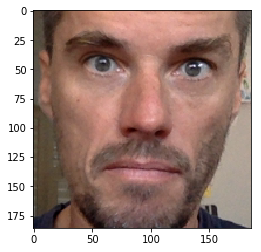

Prediction = center
Elapsed time = 625.277 ms


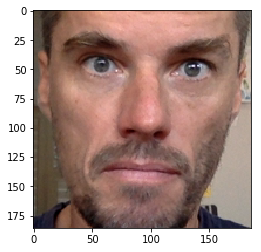

Prediction = center
Elapsed time = 686.464 ms


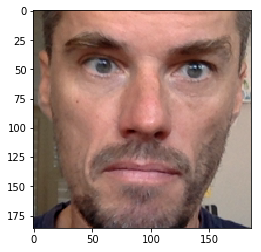

Prediction = left
Elapsed time = 614.330 ms


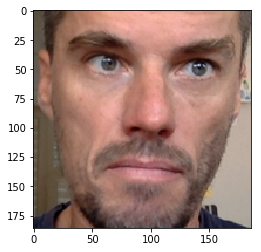

Prediction = left
Elapsed time = 678.321 ms


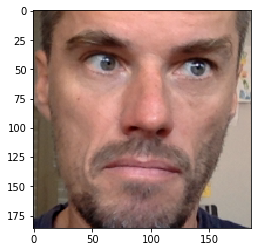

Prediction = left
Elapsed time = 639.753 ms


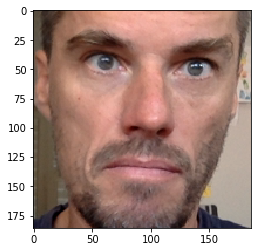

Prediction = left
Elapsed time = 700.801 ms


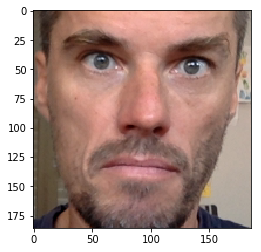

Prediction = center
Elapsed time = 693.839 ms


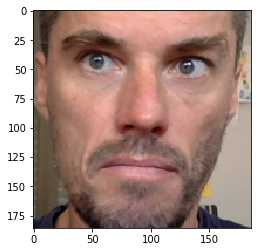

Prediction = right
Elapsed time = 632.200 ms
Capture released


In [10]:
dyn_test(N_frame=8, display=True, interframe_time=0.)        